In [1]:
%load_ext autoreload
%autoreload 2

# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training and model evaluation.

# Imports

In [2]:
# Standard library Imports
import sys
import time
import os
import warnings
import re
import random
import os.path as op


# Third Party Imports
import yaml
import hvplot
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from IPython.display import display,display_html



# Spark Imports
from pyspark.sql import (
    types as DT,
    functions as F,
    Window
)

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import (
    ParamGridBuilder,
    CrossValidator,
    CrossValidatorModel
)
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    StringIndexer,
    OneHotEncoderEstimator,
    Imputer
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics


# Project Imports
from ta_lib.pyspark import (
    dp,
    features,
    model_gen,
    model_eval,
    utils,
    eda,
    context,
    handy_spark_cd
)

from ta_lib.pyspark.utils import save_model
# Options
random.seed(0)
pn.extension('bokeh')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Initialization

`config.yml` is used to store all the parameters required for the template

In [3]:
config_path = op.join(os.getcwd(),'conf', 'config.yml')
with open(config_path, 'r') as fp:
    config = yaml.load(fp)
config

{'all': {'core': 'default',
  'log_catalog': 'production',
  'data_catalog': 'local',
  'job_catalog': 'local'},
 'spark': {'spark.executer.cores': 4, 'spark.cores.max': 4}}

In [4]:
data_config_path = op.join(os.getcwd(),'conf/data_catalog', 'remote.yml')
with open(data_config_path, 'r') as fp:
    data_config = yaml.load(fp)
data_config

{'reference_date': datetime.date(2019, 4, 26),
 'num_days_prediction': 90,
 'raw': {'filesystem': 'dbfs',
  'base_path': '/FileStore/tables/vacation_partitioned/',
  'call_data_path': 'dial_summary.parquet',
  'last_activity_data_path': 'customer_activity.parquet',
  'booking_data_path': 'class_labels.parquet',
  'consumer_data_path': 'customer.parquet',
  'web_data_path': 'itr_data_*.parquet'},
 'clean': {'filesystem': 'dbfs',
  'base_path': '/FileStore/tables/vacation_clean/',
  'call_data_path': 'dial_summary.parquet',
  'last_activity_data_path': 'customer_activity.parquet',
  'booking_data_path': 'class_labels.parquet',
  'consumer_data_path': 'customer.parquet',
  'web_data_path': 'itr_data_*.parquet'},
 'processed': {'filesystem': 'dbfs',
  'base_path': '/FileStore/tables/spark_warehouse/',
  'train': 'train.parquet',
  'test': 'test.parquet',
  'preds': 'predictions.parquet'},
 'spark': {'spark.executer.cores': 4, 'spark.cores.max': 4}}

## Create spark session

`talib.pyspark.context` module is leveraged to build the sparksession so as to consider the spark session related params in the config file while building the session.

In [5]:
%%time
session = context.CustomSparkSession(config)
session.CreateSparkSession()
spark = session.spark
sc = session.sc

Wall time: 13.1 s


# Read the Train and Test Data

In [6]:
%%time
train_data_path = data_config['processed']['base_path'] + data_config['processed']['train']
test_data_path = data_config['processed']['base_path'] + data_config['processed']['test']


train_df = dp.read_data(
    spark=spark,
    paths=[train_data_path],
    fs=data_config['processed']['filesystem'],
    fmt="parquet",
    header="true",
    inferschema="true"
)
test_df = dp.read_data(
    spark=spark,
    paths=[test_data_path],
    fs=data_config['processed']['filesystem'],
    fmt="parquet",
    header="true",
    inferschema="true"
)

train_df.count(), test_df.count()

Wall time: 14.3 s


(90647, 15883)

# Identification of columns types in the Final dataframe

In [7]:
%%time
types = {
    'numerical': dp.list_numerical_columns,
    'cat_cols': dp.list_categorical_columns,
    'date_cols': dp.list_datelike_columns,
    'bool_cols': dp.list_boolean_columns
}
utils.display_as_tabs([(k,v(train_df)) for k,v in types.items()])

Wall time: 17 ms


Tabs
    [0] JSON(list, name='numerical')
    [1] JSON(list, name='cat_cols')
    [2] JSON(list, name='date_cols')
    [3] JSON(list, name='bool_cols')

In [8]:
id_cols = 'customer_id'
num_cols = types['numerical'](train_df)
num_cols = [x for x in num_cols if x not in id_cols]
cat_cols = types['cat_cols'](train_df)

# Feature Analysis of the data

In [9]:
%%time
numerical_analysis, categorical_analysis = eda.feature_analysis_table(train_df)
utils.display_as_tabs([("numerical_analysis", numerical_analysis),("categorical_analysis", categorical_analysis)], width=1500)

Wall time: 24.7 s


Tabs
    [0] DataFrame(height=300, name='numerical_analysis', sizing_mode='fixed', value=                        co..., width=1500)
    [1] DataFrame(height=300, name='categorical_analysis', sizing_mode='fixed', value=            nunique       ..., width=1500)

# Distributions of numerical and categorical variables

In [10]:
%%time
numerical, categorical = eda.feature_density_plots(train_df, num_cols, cat_cols)
utils.display_as_tabs([("numerical feature distributions", numerical), ("categorical features distribution", categorical)])

Wall time: 28 s


Tabs
    [0] HoloViews(Layout, name='numerical feature d...)
    [1] HoloViews(Layout, name='categorical f...)

# Feature Interations
## Correlation Table and Heat Map

In [11]:
%%time
corr_table=eda.get_feature_interactions(train_df, plot='table')
corr_heatmap=eda.get_feature_interactions(train_df,plot='plot')
utils.display_as_tabs([('correlation_table', corr_table), ('correlation_heatmap', corr_heatmap)])

Wall time: 1min 17s


Tabs
    [0] DataFrame(height=300, name='correlation_table', sizing_mode='fixed', value=              ..., width=300)
    [1] HoloViews(HeatMap, name='correlation_heatmap')

# Key Drivers
## Correlation of Features wrt with target variable

In [12]:
%%time
target_var='target_var'
target_corr_table=eda.correlation_with_target(train_df, target_var, cols=num_cols)
utils.display_as_tabs([('key_drivers', target_corr_table)])

Wall time: 17.2 s


Tabs
    [0] HoloViews(Bars, name='key_drivers')

## Outlier Identification and Handling

A Custom Transformer is used to handle outliers.  
An option to either drop or cap the outliers can be passed during the transform call. 

In [13]:
%%time
outlier=dp.Outlier_Treatment(
    cols=['age','last_call_date_diff','last_act_date_diff'], 
    drop=True,
    cap=False,
    method='iqr',
    iqr_multiplier=1.5
)
outlier.fit(train_df)
train_df = outlier.transform(train_df)

{'age': {'q1': 58.0, 'q3': 72.0, 'min_b': 37.0, 'max_b': 93.0}, 'last_call_date_diff': {'q1': 1496.0, 'q3': 1998.0, 'min_b': 743.0, 'max_b': 2751.0}, 'last_act_date_diff': {'q1': 1419.0, 'q3': 1717.0, 'min_b': 972.0, 'max_b': 2164.0}}
Wall time: 13 s


## Encoding Categorical Features

An example showcasing how to create column specific pipelines and integrating them overall is presented below.

Commonly target encoding is done for categorical variables with too many levels.
We can also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
If there is one dominant level, we can use binary encoding.

In [14]:
%%time
encoder=features.Encoder(
    cols=['gender_code','state_code'],
    rules={'state_code':{'method':'target','target_col':'target_var'},'gender_code':{'method':'onehot'}}
)
encoder.fit(train_df)
train_df = encoder.transform(train_df)
test_df = encoder.transform(test_df)

gender_code {'method': 'onehot'}
{'mapper': PipelineModel_c510839471a0, 'prefix': 'onehot'}
state_code {'method': 'target', 'target_col': 'target_var'}
{'col_name': 'state_code', 'mapper': {'SC': 0.1474164133738602, 'MN': 0.10309278350515463, 'NJ': 0.1527850078084331, 'IB': 0.06349206349206349, 'DC': 0.15853658536585366, 'OR': 0.13716814159292035, 'RI': 0.16044776119402984, 'KY': 0.12910798122065728, 'WY': 0.07407407407407407, 'NH': 0.1, 'MI': 0.11626195732155997, 'NV': 0.15855354659248957, 'LB': 0.11406844106463879, 'WI': 0.12210200927357033, 'ID': 0.1888111888111888, 'BL': 0.1130952380952381, 'CT': 0.14084507042253522, 'NE': 0.13333333333333333, 'GB': 0.14822657490735838, 'MT': 0.07317073170731707, 'BR': 0.11949685534591195, 'NC': 0.16331096196868009, 'VT': 0.12962962962962962, 'MD': 0.12240663900414937, 'DE': 0.12979351032448377, 'MO': 0.12622950819672132, 'PB': 0.14013709063214014, 'IL': 0.13182286302780638, 'ME': 0.11920529801324503, 'MB': 0.13276089828269486, 'VB': 0.146285714285

## Model DataPrep and Vector Generation
### Obtaining List of Feature Columns

We use customer functions from `ta_lib.pyspark.dp` for identifying the data types of each column. We then group the columns for use as features in the model.

In [15]:
id_cols = 'customer_id'
num_cols = dp.list_numerical_columns(train_df)
cat_cols = dp.list_categorical_columns(train_df)
date_cols = dp.list_datelike_columns(train_df)
bool_cols = dp.list_boolean_columns(train_df)

target_col = 'target_var'
non_relevant_cat_cols = []
non_relevant_num_cols = [x for x in num_cols if 'index' in x]
feature_cols = train_df.columns
feature_cols = [x for x in feature_cols if x not in  cat_cols + date_cols + bool_cols + [id_cols] + non_relevant_num_cols + [target_col]]
feature_cols

['age',
 'rci_qualify_cruise_qty',
 'last_call_date_diff',
 'last_act_date_diff',
 'last_web_date_diff',
 'total_sec_spent',
 'total_page_view_count',
 'onehot_encoded_gender_code',
 'target_mean_encodedstate_code']

### Generating the Features Vector

In [16]:
%%time
train_df = dp.generate_features_vector(spark, train_df, feature_cols, output_col="features")
test_df = dp.generate_features_vector(spark, test_df, feature_cols, output_col="features")

Wall time: 32 ms


# Model Train and Eval

In [17]:
%%time
# renaming target col as y
train_df = train_df.withColumnRenamed(target_col, "y")
test_df = test_df.withColumnRenamed(target_col, "y")

Wall time: 5 ms


In [18]:
# estimator declaration
m = LogisticRegression(featuresCol="features", labelCol="y", predictionCol='yhat')
model = m.fit(train_df)

save_model(model,
          data_config['processed']['filesystem']+":"+data_config['processed']['base_path'] + "/models_vacation")

In [29]:
from pyspark.ml.classification import LogisticRegressionModel
model = LogisticRegressionModel.load(data_config['processed']['filesystem'] + ":" + data_config['processed']['base_path'] + "/models_vacation")
preds_df = model.transform(test_df)
# Save the predictions 
dp.save_data(preds_df, path = data_config["clean"]["filesystem"]+":"+data_config["processed"]["base_path"]+ data_config["processed"]["preds"])

In [30]:
preds_df.select("y","yhat","probability","rawPrediction").show(5)

+---+----+--------------------+--------------------+
|  y|yhat|         probability|       rawPrediction|
+---+----+--------------------+--------------------+
|  0| 0.0|[0.93024810547704...|[2.59050674869863...|
|  0| 0.0|[0.84459635709728...|[1.69283294956015...|
|  0| 0.0|[0.94321730706946...|[2.81006512099624...|
|  0| 0.0|[0.91478038537940...|[2.37345239459759...|
|  0| 0.0|[0.99948048904070...|[7.56210300583558...|
+---+----+--------------------+--------------------+
only showing top 5 rows



# Model Evaluation Metrics

In [31]:
%%time
bin_cls_metrics = model_eval.get_binary_classification_metrics(
    spark,
    data=preds_df,
    y_col='y',
    y_pred_cols=['yhat'],
    probability_cols=['probability'],
    threshold=0.5
)
bin_cls_metrics.show()

+---------+----+
|   metric|yhat|
+---------+----+
| Accuracy|0.88|
| F1 Score|0.02|
|      TPR|0.01|
|      FPR| 0.0|
|Precision|0.41|
|   Recall|0.01|
|    AuROC|0.75|
|     AuPR| 0.3|
+---------+----+

Wall time: 37.2 s


# Classification Plots

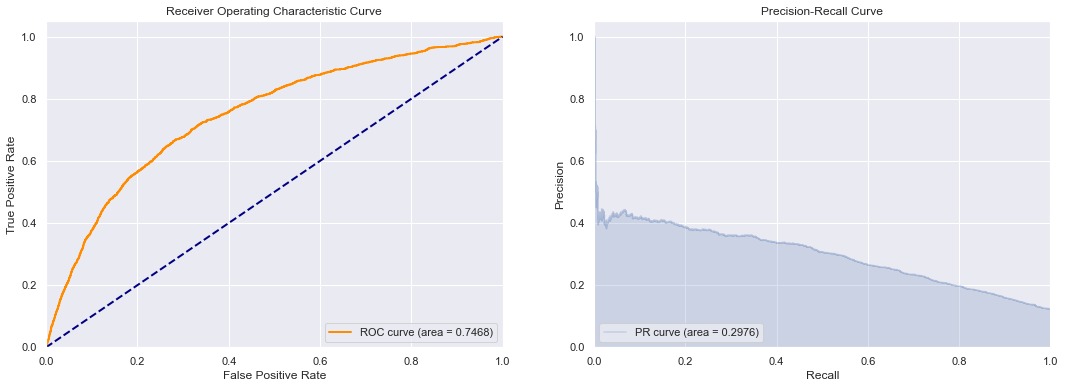

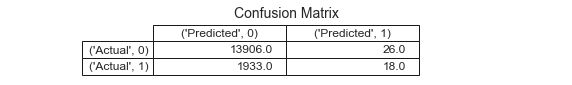

Wall time: 54.5 s


In [32]:
%%time
model_eval.get_binary_classification_plots(
    spark,
    data=preds_df,
    y_col='y',
    y_pred_col='yhat',
    probability_col='probability',
    threshold=0.5
)

### Classification Plots with Evaluation wrt Feature

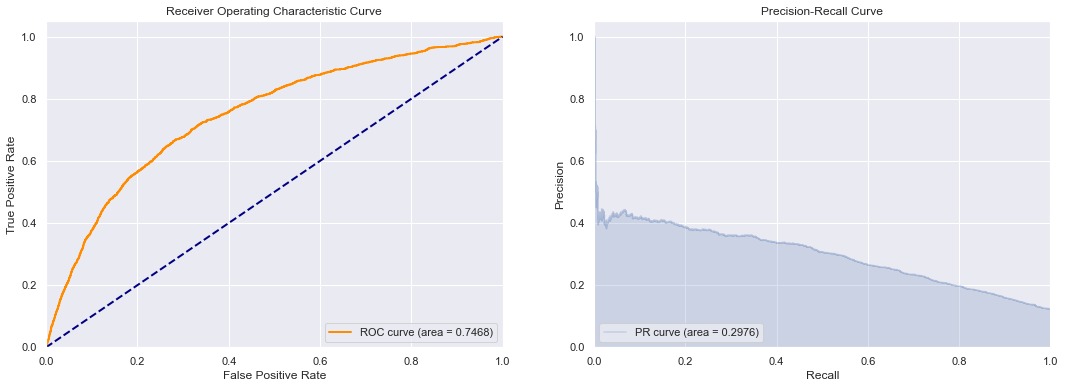

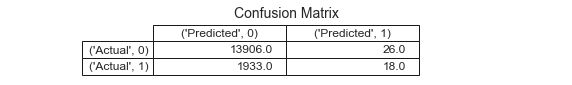

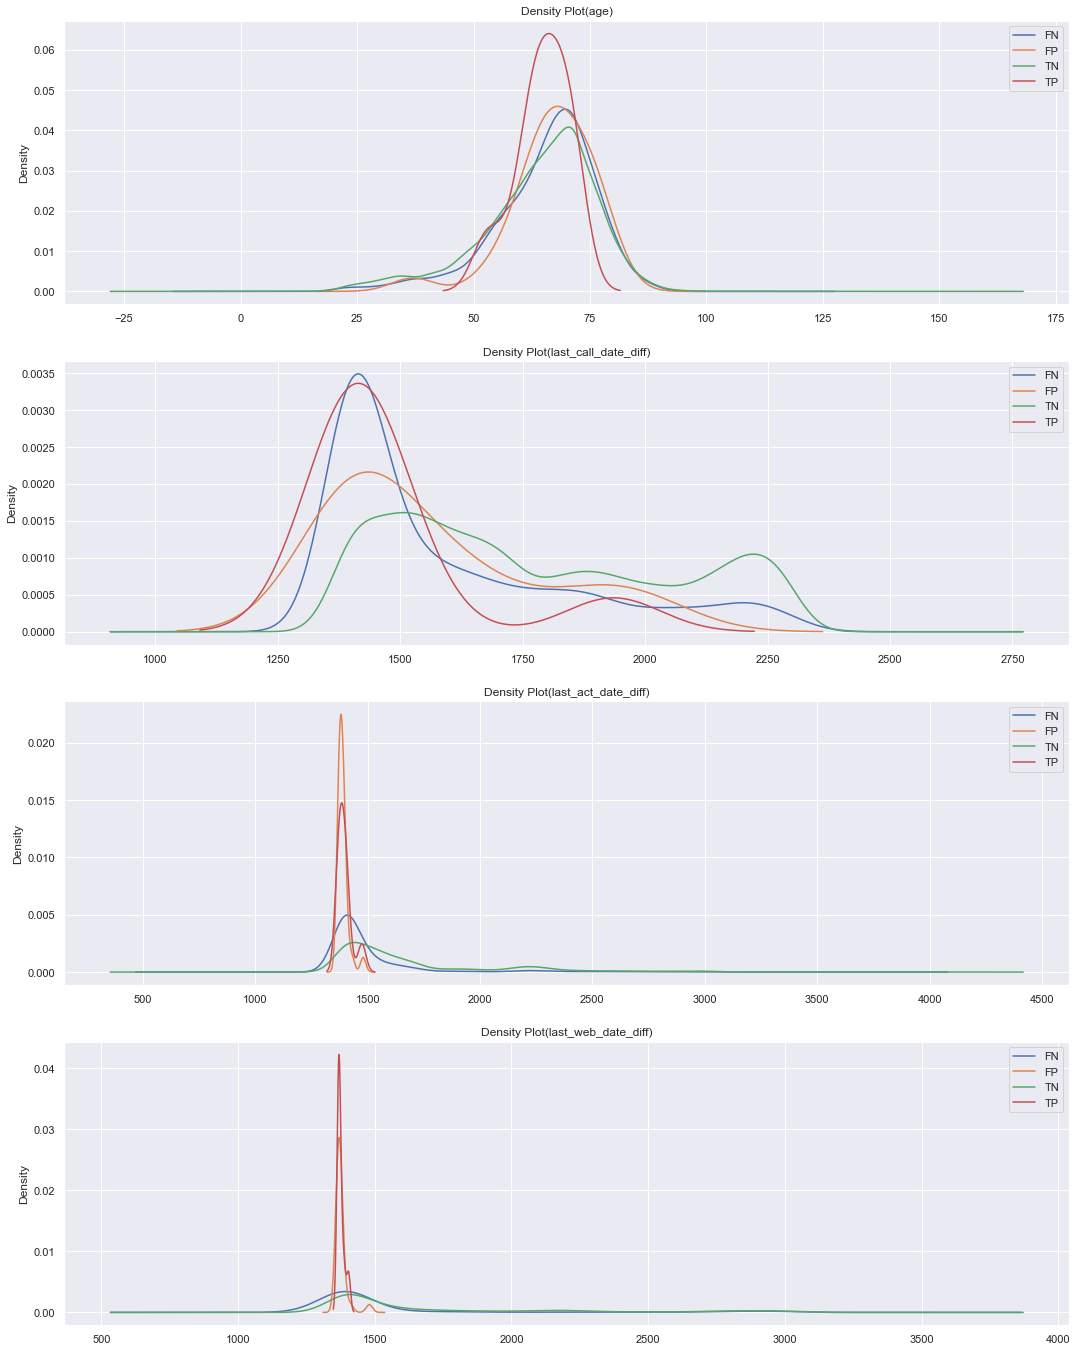

Wall time: 1min 19s


In [28]:
%%time
model_eval.get_binary_classification_plots(
    spark, data=preds_df,
    y_col='y',
    y_pred_col='yhat',
    probability_col='probability',
    threshold=0.5,
    feature_cols=['age','last_call_date_diff','last_act_date_diff','last_web_date_diff'],
    feature_plots=True # this argument is added here when compared to previous cell
)